# Segmenting and Clustering Neighbourhoods in Toronto

## Part 1: Scraping and preprocessing postal code data

#### Obtaining postal data

We will be obtaining Toronto postal code data from the following table https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M and converting it to a Pandas Dataframe

In [1]:
import pandas as pd
url = 'https://en.wikipedia.org/wiki/List_of_postal_codes_of_Canada:_M'


In [2]:
#Use Pandas to read the first table on the webpage into a dataframe 
df_postalcodes = pd.read_html(url)[0]


In [3]:
#Inspect top rows of dataframe
df_postalcodes.head(10)

,Postal Code,Borough,Neighbourhood
0,M1A,Not assigned,Not assigned
1,M2A,Not assigned,Not assigned
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
7,M8A,Not assigned,Not assigned
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village"
9,M1B,Scarborough,"Malvern, Rouge"


Lets see the initial shape of the table before we refine it

In [4]:
df_postalcodes.shape

(180, 3)

It initially has 180 records and 3 columns

#### Preprocessing postal data

The requirements state to only process rows that are assigned to boroughs, so we will drop all "Not assigned" rows

In [5]:
df_postalcodes = df_postalcodes[df_postalcodes['Borough'] != "Not assigned"]

In [6]:
df_postalcodes

,Postal Code,Borough,Neighbourhood
2,M3A,North York,Parkwoods
3,M4A,North York,Victoria Village
4,M5A,Downtown Toronto,"Regent Park, Harbourfront"
5,M6A,North York,"Lawrence Manor, Lawrence Heights"
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government"
...,...,...,...
160,M8X,Etobicoke,"The Kingsway, Montgomery Road, Old Mill North"
165,M4Y,Downtown Toronto,Church and Wellesley
168,M7Y,East Toronto,"Business reply mail Processing Centre, South C..."
169,M8Y,Etobicoke,"Old Mill South, King's Mill Park, Sunnylea, Hu..."


The requirements state to group every postal code that is assigned to multiple neighbourhoods together, seperated by comas. So we will find out how many rows contain the same postal code.

In [7]:
occurances = df_postalcodes['Postal Code'].value_counts()

for index, val in occurances.items():
    if(val > 1):
        print(index, " appears more than once")

Running this code we find there are no occurances of postal codes appearing on more than once. Inspecting the table further reveals the wikipedia page has been updated to group all neighbourhoods with the same postal code together.

Next, we are to assign the borough name to the Neighbourhood column if the Neighbourhood is not assigned. Lets create a boolean mask of all rows with unassigned Neighbourhoods and filter the dataframe to see if there are any occurances.

In [8]:
occurances = df_postalcodes['Neighbourhood'] == 'Not assigned'
df_postalcodes[occurances]

,Postal Code,Borough,Neighbourhood


The output table is empty, indicating there are no postal codes without assigned neighbourhoods left in the dataframe and no further processing is required. 

Finally, lets see the shape of the refined table

In [9]:
df_postalcodes.shape

(103, 3)

There are 103 records and 3 columns in the table.

## Part 2: Obtaining location data

We will now use the Geocoder Python package to get lattitude and longitude coordinates of each neighbourhood

In [10]:
!pip install geocoder # install geocoder library
import geocoder # import geocoder

     |████████████████████████████████| 98 kB 6.2 MB/s eta 0:00:011


We will loop through each postal code in the dataframe and make API calls to the geocoder service. Due to the unreliable nature of the geocoder API it sometimes takes multiple calls to recieve a response and therefore we will loop for each code until a response is recieved.


In [11]:
lat = []
long = []

for code in df_postalcodes['Postal Code']:
    lat_lng_coords = None
    
    while (lat_lng_coords is None):
        g = geocoder.arcgis('{}, Toronto, Ontario'.format(code))
        lat_lng_coords = g.latlng
        #print(code, g.latlng)

    lat.append(lat_lng_coords[0])
    long.append(lat_lng_coords[1])


Now lets append those lattitude and longitude lists to the dataframe

In [12]:
df_postalcodes['Latitude'] = lat
df_postalcodes['Longitude'] = long

df_postalcodes.head()

,Postal Code,Borough,Neighbourhood,Latitude,Longitude
2,M3A,North York,Parkwoods,43.75245,-79.32991
3,M4A,North York,Victoria Village,43.73057,-79.31306
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264
5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188


## Part 3: Clustering neighbourhoods


In this section we will utilize the FourSquare API to request data of the different venues in each neighbourhood, and then use KNN clustering to group each neighbourhood into categories. 

In [13]:
import numpy as np # library to handle data in a vectorized manner

import json # library to handle JSON files

#!conda install -c conda-forge geopy --yes # uncomment if not installed
from geopy.geocoders import Nominatim # convert an address into latitude and longitude values

import requests # library to handle requests
from pandas.io.json import json_normalize # tranform JSON file into a pandas dataframe
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

# Matplotlib and associated plotting modules
import matplotlib.cm as cm
import matplotlib.colors as colors

# import k-means from clustering stage
from sklearn.cluster import KMeans

!pip install folium
#!conda install -c conda-forge folium=0.5.0 --yes # uncomment if not installed
import folium # map rendering library

print('Libraries imported.')

     |████████████████████████████████| 93 kB 3.1 MB/s  eta 0:00:01
Libraries imported.


#### Mapping

Using the geopy library, we will obtain the coordinates of Toronto

In [14]:
address = 'Toronto, ON'

geolocator = Nominatim(user_agent="toronto_explorer")
location = geolocator.geocode(address)
latitude = location.latitude
longitude = location.longitude
print('The geograpical coordinates of Toronto are {}, {}.'.format(latitude, longitude))

The geograpical coordinates of Toronto are 43.6534817, -79.3839347.


We will create a map centered on Toronto and superimpose markers for each neighbourhood

In [15]:
# create map of Toronto using latitude and longitude values
map_toronto = folium.Map(location=[latitude, longitude], zoom_start=10)

# add markers to map
for lat, lng, borough, Neighbourhood in zip(df_postalcodes['Latitude'], df_postalcodes['Longitude'], df_postalcodes['Borough'], df_postalcodes['Neighbourhood']):
    label = '{}, {}'.format(Neighbourhood, borough)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
        [lat, lng],
        radius=5,
        popup=label,
        color='blue',
        fill=True,
        fill_color='#3186cc',
        fill_opacity=0.7,
        parse_html=False).add_to(map_toronto)  
    
map_toronto

### Using FourSquare API

We will use the FourSquare API to obtain all the venues within a 500m radius around the center of each group of neighbourhoods (by postal code)

My API credentials are hidden in the cell below, for security

In [16]:
# The code was removed by Watson Studio for sharing.

In [17]:
VERSION = '20180605' # Foursquare API version
LIMIT = 100 # A default Foursquare API limit value

We will make a test API call to see the JSON object returned

In [18]:
radius = 500

url = 'https://api.foursquare.com/v2/venues/explore?client_id={}&client_secret={}&ll={},{}&v={}&radius={}&limit={}'.format(CLIENT_ID, CLIENT_SECRET, 43.75245, -79.32991, VERSION, radius, LIMIT)

results = requests.get(url).json()
results

{'meta': {'code': 200, 'requestId': '5fcb1b380eaaa81c1b509c56'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Parkwoods - Donalda',
  'headerFullLocation': 'Parkwoods - Donalda, Toronto',
  'headerLocationGranularity': 'neighborhood',
  'totalResults': 2,
  'suggestedBounds': {'ne': {'lat': 43.756950004500005,
    'lng': -79.3236918238658},
   'sw': {'lat': 43.7479499955, 'lng': -79.3361281761342}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4e8d9dcdd5fbbbb6b3003c7b',
       'name': 'Brookbanks Park',
       'location': {'address': 'Toronto',
        'lat': 43.751976046055574,
        'lng': -79.33214044722958,
        'labeledLatLngs': [{

Lets define a function to extract venue type from results

In [19]:
# function that extracts the category of the venue
def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

Clean JSON data

In [20]:
venues = results['response']['groups'][0]['items']
    
nearby_venues = pd.json_normalize(venues) # flatten JSON

# filter columns
filtered_columns = ['venue.name', 'venue.categories', 'venue.location.lat', 'venue.location.lng']
nearby_venues =nearby_venues.loc[:, filtered_columns]

# filter the category for each row
nearby_venues['venue.categories'] = nearby_venues.apply(get_category_type, axis=1)

# clean columns
nearby_venues.columns = [col.split(".")[-1] for col in nearby_venues.columns]

nearby_venues.head()

,name,categories,lat,lng
0,Brookbanks Park,Park,43.751976,-79.332140
1,Variety Store,Food & Drink Shop,43.751974,-79.333114


lets now create a function to repeat this for each neighbourhood

In [21]:
def getNearbyVenues(names, latitudes, longitudes, radius=500):
    
    venues_list=[]
    for name, lat, lng in zip(names, latitudes, longitudes):
        print(name)
            
        # create the API request URL
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            LIMIT)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighbourhood', 
                  'Neighbourhood Latitude', 
                  'Neighbourhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

And now we shall run it

In [22]:
toronto_venues = getNearbyVenues(names = df_postalcodes['Neighbourhood'], latitudes = df_postalcodes['Latitude'],longitudes = df_postalcodes['Longitude'])

Parkwoods
Victoria Village
Regent Park, Harbourfront
Lawrence Manor, Lawrence Heights
Queen's Park, Ontario Provincial Government
Islington Avenue, Humber Valley Village
Malvern, Rouge
Don Mills
Parkview Hill, Woodbine Gardens
Garden District, Ryerson
Glencairn
West Deane Park, Princess Gardens, Martin Grove, Islington, Cloverdale
Rouge Hill, Port Union, Highland Creek
Don Mills
Woodbine Heights
St. James Town
Humewood-Cedarvale
Eringate, Bloordale Gardens, Old Burnhamthorpe, Markland Wood
Guildwood, Morningside, West Hill
The Beaches
Berczy Park
Caledonia-Fairbanks
Woburn
Leaside
Central Bay Street
Christie
Cedarbrae
Hillcrest Village
Bathurst Manor, Wilson Heights, Downsview North
Thorncliffe Park
Richmond, Adelaide, King
Dufferin, Dovercourt Village
Scarborough Village
Fairview, Henry Farm, Oriole
Northwood Park, York University
East Toronto, Broadview North (Old East York)
Harbourfront East, Union Station, Toronto Islands
Little Portugal, Trinity
Kennedy Park, Ionview, East Birchmo

Now lets observe the resulting dataframe

In [23]:
toronto_venues.head()

,Neighbourhood,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
0,Parkwoods,43.75245,-79.32991,Brookbanks Park,43.751976,-79.332140,Park
1,Parkwoods,43.75245,-79.32991,Variety Store,43.751974,-79.333114,Food & Drink Shop
2,Victoria Village,43.73057,-79.31306,Wigmore Park,43.731023,-79.310771,Park
3,Victoria Village,43.73057,-79.31306,Memories of Africa,43.726602,-79.312427,Grocery Store
4,Victoria Village,43.73057,-79.31306,Guardian Drug,43.730584,-79.307432,Pharmacy


And lets see how many of each venue are in each group of neighbourhoods

In [24]:
toronto_venues.groupby('Neighbourhood').count()

,Neighbourhood Latitude,Neighbourhood Longitude,Venue,Venue Latitude,Venue Longitude,Venue Category
Neighbourhood,,,,,,
Agincourt,16,16,16,16,16,16
"Alderwood, Long Branch",4,4,4,4,4,4
Bayview Village,4,4,4,4,4,4
"Bedford Park, Lawrence Manor East",19,19,19,19,19,19
Berczy Park,60,60,60,60,60,60
"Birch Cliff, Cliffside West",4,4,4,4,4,4
"Brockton, Parkdale Village, Exhibition Place",85,85,85,85,85,85
"Business reply mail Processing Centre, South Central Letter Processing Plant Toronto",100,100,100,100,100,100
"CN Tower, King and Spadina, Railway Lands, Harbourfront West, Bathurst Quay, South Niagara, Island airport",76,76,76,76,76,76


### Analyising Data

Now lets briefly look at some of the trends in the dataset

We will use one-hot encoding to prepare for averaging the frequency of venue type in each Neighbourhood

In [25]:
# one hot encoding
toronto_onehot = pd.get_dummies(toronto_venues[['Venue Category']], prefix="", prefix_sep="")

# Move Neighbourhood column to first index
first_col = toronto_venues.get('Neighbourhood')
#toronto_onehot = toronto_onehot.drop(columns=['Neighbourhood'])
toronto_onehot.insert(0, 'Neighbourhood', first_col)

toronto_onehot.head()

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Parkwoods,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,

Lets take the venue frequency mean for each group of neighbourhoods

In [26]:
toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()
toronto_grouped

,Neighbourhood,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,Agincourt,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.

Now lets view the 5 most frequent venues in each group to get a feel for how they could potentially be classified

In [27]:
num_top_venues = 5

for hood in toronto_grouped['Neighbourhood']:
    print("----"+hood+"----")
    temp = toronto_grouped[toronto_grouped['Neighbourhood'] == hood].T.reset_index()
    temp.columns = ['venue','freq']
    temp = temp.iloc[1:]
    temp['freq'] = temp['freq'].astype(float)
    temp = temp.round({'freq': 2})
    print(temp.sort_values('freq', ascending=False).reset_index(drop=True).head(num_top_venues))
    print('\n')

----Agincourt----
                 venue  freq
0   Chinese Restaurant  0.12
1        Grocery Store  0.06
2      Badminton Court  0.06
3  Shanghai Restaurant  0.06
4            Newsagent  0.06


----Alderwood, Long Branch----
                   venue  freq
0      Convenience Store  0.25
1                    Pub  0.25
2  Performing Arts Venue  0.25
3                    Gym  0.25
4      Accessories Store  0.00


----Bayview Village----
                        venue  freq
0          Golf Driving Range  0.25
1  Construction & Landscaping  0.25
2                       Trail  0.25
3                        Park  0.25
4                Neighborhood  0.00


----Bedford Park, Lawrence Manor East----
                venue  freq
0      Sandwich Place  0.11
1         Coffee Shop  0.11
2  Italian Restaurant  0.11
3           Juice Bar  0.05
4    Sushi Restaurant  0.05


----Berczy Park----
            venue  freq
0     Coffee Shop  0.08
1      Restaurant  0.03
2          Bakery  0.03
3  Breakfast Spot

#### Observations

Lets look at the first 3 areas that appear alphabetically and observe some trends

1. Agincourt has many Asian resturants so it might be an area with many Asian residents
2. Alderwood/Long Branch looks like an urban area with convenidence stores, pubs, gyms, and performing arts venues
3. Bayview Village has many golfing ranges, trails, parks, and construction areas indicating it is a more rural area that is under developement 


Lets sort the venues in each neighbourhood in decending order

Here is a function to accomplish that task

In [28]:
def return_most_common_venues(row, num_top_venues):
    row_categories = row.iloc[1:]
    row_categories_sorted = row_categories.sort_values(ascending=False)
    
    return row_categories_sorted.index.values[0:num_top_venues]

Lets create a new dataframe to store the Neighbourhoods and their venues sorted by frequency

In [29]:
num_top_venues = 10

indicators = ['st', 'nd', 'rd']

# create columns according to number of top venues
columns = ['Neighbourhood']
for ind in np.arange(num_top_venues):
    try:
        columns.append('{}{} Most Common Venue'.format(ind+1, indicators[ind]))
    except:
        columns.append('{}th Most Common Venue'.format(ind+1))

# create a new dataframe
Neighbourhoods_venues_sorted = pd.DataFrame(columns=columns)
Neighbourhoods_venues_sorted['Neighbourhood'] = toronto_grouped['Neighbourhood']

for ind in np.arange(toronto_grouped.shape[0]):
    Neighbourhoods_venues_sorted.iloc[ind, 1:] = return_most_common_venues(toronto_grouped.iloc[ind, :], num_top_venues)

Neighbourhoods_venues_sorted.head()

,Neighbourhood,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
0,Agincourt,Chinese Restaurant,Hong Kong Restaurant,Discount Store,Skating Rink,Shopping Mall,Shanghai Restaurant,Supermarket,Sushi Restaurant,Bubble Tea Shop,Badminton Court
1,"Alderwood, Long Branch",Convenience Store,Gym,Pub,Performing Arts Venue,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant
2,Bayview Village,Construction & Landscaping,Park,Golf Driving Range,Trail,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant
3,"Bedford Park, Lawrence Manor East",Coffee Shop,Sandwich Place,Italian Restaurant,Comfort Food Restaurant,Pharmacy,Butcher,Café,Sports Club,Liquor Store,Sushi Restaurant
4,Berczy Park,Coffee Shop,Cheese Shop,Cocktail Bar,Breakfast Spot,Beer Bar,Bakery,Restaurant,Seafood Restaurant,Farmers Market,Sandwich Place


### Clustering Each Neighbourhood

To begin, lets determine the optimal k value

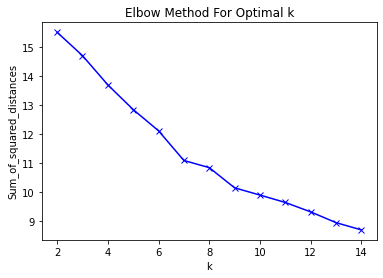

In [32]:
import matplotlib.pyplot as plt


toronto_grouped = toronto_onehot.groupby('Neighbourhood').mean().reset_index()

toronto_grouped_clustering = toronto_grouped.drop('Neighbourhood', 1)


inertia=[]

for k in range(2, 15):
    kmeans = KMeans(n_clusters=k, random_state=0).fit(toronto_grouped_clustering)
    inertia.append(kmeans.inertia_)

plt.plot(range(2,15), inertia, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()


The elbow is at k = 6, so lets use that

In [33]:
# set number of clusters
kclusters = 6


# run k-means clustering
kmeans = KMeans(n_clusters=kclusters, random_state=0).fit(toronto_grouped_clustering)

# check cluster labels generated for each row in the dataframe
kmeans.labels_[0:100] 

array([1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 3, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1,
       1, 1, 1, 0, 0, 1, 1, 2, 1, 1, 1, 0, 1, 0, 2, 5, 0, 0, 1, 1, 1, 1,
       1, 1, 1, 1, 1, 5, 1, 1, 1, 0, 2, 0, 1, 1, 1, 1, 1, 2, 1, 1, 1, 0,
       0, 1, 5, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 1, 1,
       4, 1, 1, 0, 0, 1, 0, 2], dtype=int32)

In [34]:
toronto_grouped_clustering

,Accessories Store,Afghan Restaurant,American Restaurant,Antique Shop,Aquarium,Art Gallery,Art Museum,Arts & Crafts Store,Asian Restaurant,Athletics & Sports,Auto Dealership,Auto Garage,Auto Workshop,Automotive Shop,BBQ Joint,Baby Store,Badminton Court,Bagel Shop,Bakery,Bank,Bar,Baseball Field,Basketball Stadium,Beer Bar,Beer Store,Belgian Restaurant,Bike Shop,Bike Trail,Bistro,Boat or Ferry,Bookstore,Boutique,Brazilian Restaurant,Breakfast Spot,Brewery,Bridge,Bubble Tea Shop,Burger Joint,Burrito Place,Bus Line,Bus Station,Bus Stop,Business Service,Butcher,Café,Camera Store,Candy Store,Cantonese Restaurant,Caribbean Restaurant,Cheese Shop,Chinese Restaurant,Chiropractor,Chocolate Shop,Church,Climbing Gym,Clothing Store,Cocktail Bar,Coffee Shop,College Arts Building,College Gym,College Rec Center,College Stadium,Colombian Restaurant,Comfort Food Restaurant,Comic Shop,Concert Hall,Construction & Landscaping,Convenience Store,Cosmetics Shop,Costume Shop,Creperie,Cuban Restaurant,Cupcake Shop,Dance Studio,Deli / Bodega,Department Store,Dessert Shop,Dim Sum Restaurant,Diner,Discount Store,Distribution Center,Dog Run,Donut Shop,Dumpling Restaurant,Eastern European Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Farmers Market,Fast Food Restaurant,Field,Fish & Chips Shop,Fish Market,Flea Market,Flower Shop,Food,Food & Drink Shop,Food Court,Food Truck,Fountain,French Restaurant,Fried Chicken Joint,Frozen Yogurt Shop,Furniture / Home Store,Gaming Cafe,Garden,Gas Station,Gastropub,Gay Bar,General Entertainment,General Travel,German Restaurant,Gift Shop,Gluten-free Restaurant,Golf Course,Golf Driving Range,Gourmet Shop,Greek Restaurant,Grocery Store,Gym,Gym / Fitness Center,Gym Pool,Hardware Store,Hawaiian Restaurant,Health Food Store,Historic Site,History Museum,Hobby Shop,Hockey Arena,Home Service,Hong Kong Restaurant,Hookah Bar,Hotel,Hotel Bar,IT Services,Ice Cream Shop,Indian Restaurant,Indoor Play Area,Intersection,Irish Pub,Italian Restaurant,Japanese Restaurant,Jazz Club,Jewelry Store,Juice Bar,Kitchen Supply Store,Korean Restaurant,Lake,Latin American Restaurant,Leather Goods Store,Light Rail Station,Lingerie Store,Liquor Store,Lounge,Luggage Store,Malay Restaurant,Market,Martial Arts School,Massage Studio,Mattress Store,Mediterranean Restaurant,Men's Store,Metro Station,Mexican Restaurant,Middle Eastern Restaurant,Miscellaneous Shop,Mobile Phone Shop,Modern European Restaurant,Molecular Gastronomy Restaurant,Monument / Landmark,Moroccan Restaurant,Movie Theater,Moving Target,Museum,Music Venue,Neighborhood,New American Restaurant,Newsagent,Nightclub,Noodle House,Office,Opera House,Optical Shop,Organic Grocery,Other Great Outdoors,Other Nightlife,Park,Performing Arts Venue,Peruvian Restaurant,Pet Store,Pharmacy,Pilates Studio,Pizza Place,Platform,Playground,Plaza,Poke Place,Pool,Portuguese Restaurant,Poutine Place,Print Shop,Pub,Ramen Restaurant,Record Shop,Rental Car Location,Residential Building (Apartment / Condo),Restaurant,Road,Rock Climbing Spot,Roof Deck,Sake Bar,Salad Place,Salon / Barbershop,Sandwich Place,Sculpture Garden,Seafood Restaurant,Shanghai Restaurant,Shoe Store,Shop & Service,Shopping Mall,Skating Rink,Smoke Shop,Smoothie Shop,Snack Place,Soccer Field,Soup Place,Southern / Soul Food Restaurant,Souvlaki Shop,Spa,Speakeasy,Sporting Goods Shop,Sports Bar,Sports Club,Stadium,Steakhouse,Storage Facility,Strip Club,Supermarket,Supplement Shop,Sushi Restaurant,Swim School,Taco Place,Tailor Shop,Taiwanese Restaurant,Tanning Salon,Tea Room,Tennis Court,Thai Restaurant,Theater,Theme Restaurant,Thrift / Vintage Store,Toy / Game Store,Trail,Train Station,Turkish Restaurant,Vegetarian / Vegan Restaurant,Veterinarian,Video Game Store,Video Store,Vietnamese Restaurant,Wine Bar,Wine Shop,Wings Joint,Women's Store,Yoga Studio,Zoo Exhibit
0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000,0.0,0.00000,0.000000,0.000

Merge postal code data with venue data

In [35]:
# add clustering labels
Neighbourhoods_venues_sorted.insert(0, 'Cluster Labels', kmeans.labels_)

toronto_merged = df_postalcodes

# merge manhattan_grouped with manhattan_data to add latitude/longitude for each Neighbourhood
toronto_merged = toronto_merged.join(Neighbourhoods_venues_sorted.set_index('Neighbourhood'), on='Neighbourhood')

toronto_merged # check the last columns!

,Postal Code,Borough,Neighbourhood,Latitude,Longitude,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,M3A,North York,Parkwoods,43.75245,-79.32991,2.0,Food & Drink Shop,Park,Falafel Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Farm,Dumpling Restaurant
3,M4A,North York,Victoria Village,43.73057,-79.31306,0.0,Park,Pharmacy,Grocery Store,Zoo Exhibit,Event Space,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Falafel Restaurant
4,M5A,Downtown Toronto,"Regent Park, Harbourfront",43.65512,-79.36264,1.0,Coffee Shop,Breakfast Spot,Pub,Electronics Store,Distribution Center,Bakery,Restaurant,Thai Restaurant,Theater,Italian Restaurant
5,M6A,North York,"Lawrence Manor, Lawrence Heights",43.72327,-79.45042,1.0,Clothing Store,Furniture / Home Store,Coffee Shop,Toy / Game Store,Women's Store,Cosmetics Shop,American Restaurant,Bookstore,Food Court,Men's Store
6,M7A,Downtown Toronto,"Queen's Park, Ontario Provincial Government",43.66253,-79.39188,1.0,Coffee Shop,Sandwich Place,Burrito Place,Café,Theater,Fried Chicken Joint,Italian Restaurant,Gastropub,Falafel Restaurant,Park
8,M9A,Etobicoke,"Islington Avenue, Humber Valley Village",43.66263,-79.52831,1.0,Pharmacy,Skating Rink,Café,Shopping Mall,Park,Bank,Grocery Store,Zoo Exhibit,Elementary School,Escape Room
9,M1B,Scarborough,"Malvern, Rouge",43.81139,-79.19662,5.0,Zoo Exhibit,Furniture / Home Store,Fast Food Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Field,Flower Shop,Food & Drink Shop,Farmers Market
11,M3B,North York,Don Mills,43.74923,-79.36186,1.0,Coffee Shop,Intersection,Burger Joint,Gym,Gas Station,Soccer Field,Supermarket,Grocery Store,Beer Store,Smoke Shop
12,M4B,East York,"Parkview Hill, Woodbine Gardens",43.70718,-79.31192,1.0,Pizza Place,Intersection,Pharmacy,Pet Store,Rock Climbing Spot,Café,Fast Food Restaurant,Bus Line,Breakfast Spot,Gastropub
13,M5B,Downtown Toronto,"Garden District, Ryerson",43.65739,-79.37804,1.0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Furniture / Home Store,Theater,Chinese Restaurant,Hotel


#### Removing NaN rows

If you look through the dataframe you will notice some rows have NaN values. Turns out the FourSquare API didn't have any data for venues within 500m of those areas. So we will simply remove those rows.

In [36]:
toronto_merged = toronto_merged.dropna()

#### Visualizing Clusters

In [37]:
# create map
map_clusters = folium.Map(location=[latitude, longitude], zoom_start=11)

# set color scheme for the clusters
x = np.arange(kclusters)
ys = [i + x + (i*x)**2 for i in range(kclusters)]
colors_array = cm.rainbow(np.linspace(0, 1, len(ys)))
rainbow = [colors.rgb2hex(i) for i in colors_array]

# add markers to the map
markers_colors = []
for lat, lon, poi, cluster in zip(toronto_merged['Latitude'], toronto_merged['Longitude'], toronto_merged['Neighbourhood'], toronto_merged['Cluster Labels']):
    label = folium.Popup(str(poi) + ' Cluster ' + str(cluster), parse_html=True)
    folium.CircleMarker(
        [lat, lon],
        radius=5,
        popup=label,
        color=rainbow[int(cluster-1)],
        fill=True,
        fill_color=rainbow[int(cluster-1)],
        fill_opacity=0.7).add_to(map_clusters)
       
map_clusters

#### Classifications

Now that we have fitted the neighbourhoods into 6 different clusters using KNN, we must now determine what each classification actually represents by observing the patterns of venues in each class.

##### Cluster 0

In [38]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 0, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
3,North York,0.0,Park,Pharmacy,Grocery Store,Zoo Exhibit,Event Space,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Falafel Restaurant
18,Scarborough,0.0,Construction & Landscaping,Bar,Farm,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Food & Drink Shop
23,York,0.0,Hockey Arena,Park,Field,Trail,Grocery Store,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space
26,Etobicoke,0.0,Grocery Store,Electronics Store,Fish & Chips Shop,Shopping Mall,College Rec Center,Park,Zoo Exhibit,Elementary School,Escape Room,Ethiopian Restaurant
27,Scarborough,0.0,Construction & Landscaping,Park,Gym / Fitness Center,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Dumpling Restaurant
36,Scarborough,0.0,Construction & Landscaping,Coffee Shop,Park,Business Service,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Eastern European Restaurant
54,Scarborough,0.0,Spa,Park,Restaurant,Indian Restaurant,Grocery Store,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space
57,East York,0.0,Convenience Store,Park,Intersection,Fish Market,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Farm,Dumpling Restaurant
64,North York,0.0,Construction & Landscaping,Park,Golf Driving Range,Trail,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant
66,East Toronto,0.0,Coffee Shop,Bus Line,Ice Cream Shop,Business Service,Intersection,Discount Store,Park,Grocery Store,Zoo Exhibit,Escape Room


It appears like cluster 0 are rural areas with lots of farms, parks, fields, etc.

##### Cluster 1

In [39]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 1, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
4,Downtown Toronto,1.0,Coffee Shop,Breakfast Spot,Pub,Electronics Store,Distribution Center,Bakery,Restaurant,Thai Restaurant,Theater,Italian Restaurant
5,North York,1.0,Clothing Store,Furniture / Home Store,Coffee Shop,Toy / Game Store,Women's Store,Cosmetics Shop,American Restaurant,Bookstore,Food Court,Men's Store
6,Downtown Toronto,1.0,Coffee Shop,Sandwich Place,Burrito Place,Café,Theater,Fried Chicken Joint,Italian Restaurant,Gastropub,Falafel Restaurant,Park
8,Etobicoke,1.0,Pharmacy,Skating Rink,Café,Shopping Mall,Park,Bank,Grocery Store,Zoo Exhibit,Elementary School,Escape Room
11,North York,1.0,Coffee Shop,Intersection,Burger Joint,Gym,Gas Station,Soccer Field,Supermarket,Grocery Store,Beer Store,Smoke Shop
12,East York,1.0,Pizza Place,Intersection,Pharmacy,Pet Store,Rock Climbing Spot,Café,Fast Food Restaurant,Bus Line,Breakfast Spot,Gastropub
13,Downtown Toronto,1.0,Coffee Shop,Clothing Store,Café,Cosmetics Shop,Japanese Restaurant,Bubble Tea Shop,Furniture / Home Store,Theater,Chinese Restaurant,Hotel
14,North York,1.0,Grocery Store,Pizza Place,Mediterranean Restaurant,Fast Food Restaurant,Gas Station,Latin American Restaurant,Bank,Japanese Restaurant,Rental Car Location,Bakery
17,Etobicoke,1.0,Pizza Place,Chinese Restaurant,Print Shop,Tea Room,Sandwich Place,Field,Fast Food Restaurant,Farmers Market,Farm,Donut Shop
20,North York,1.0,Coffee Shop,Intersection,Burger Joint,Gym,Gas Station,Soccer Field,Supermarket,Grocery Store,Beer Store,Smoke Shop


Cluster 1 clearly makes up the bulk of Toronto neighbourhoods, and it is made up of very urban areas. The most frequent venues are coffee shops,  shopping districts, resturaunts, etc.

##### Cluster 2

In [40]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 2, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
2,North York,2.0,Food & Drink Shop,Park,Falafel Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Farm,Dumpling Restaurant
46,North York,2.0,Park,Residential Building (Apartment / Condo),Zoo Exhibit,Falafel Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Farm
73,North York,2.0,Park,Zoo Exhibit,Falafel Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Farm,Dumpling Restaurant
77,North York,2.0,Bakery,Park,Falafel Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Zoo Exhibit,Eastern European Restaurant
103,Central Toronto,2.0,French Restaurant,Park,Zoo Exhibit,Farm,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market


Cluster 2 appears to be suburban with parks, resturants, and schools. Farms are also fairly frequent in these areas. 

##### Cluster 3

In [41]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 3, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
45,Scarborough,3.0,Trail,Zoo Exhibit,Falafel Restaurant,Electronics Store,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Farm,Dumpling Restaurant


Cluster 3 is apparently an outliner with no similar places like it. Strangely it looks very similar to cluster 2. Perhaps the high frequency of trails and zoo exhibits threw the KNN off?

##### Cluster 4

In [42]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 4, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
108,Scarborough,4.0,Auto Garage,Zoo Exhibit,Farm,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farmers Market,Eastern European Restaurant


Cluster 4 is yet another apparent outlier, with the high auto garage frequency probably throwing the KNN calculation off. Once again it looks like cluster two. 

##### Cluster 5

In [43]:
toronto_merged.loc[toronto_merged['Cluster Labels'] == 5, toronto_merged.columns[[1] + list(range(5, toronto_merged.shape[1]))]]

,Borough,Cluster Labels,1st Most Common Venue,2nd Most Common Venue,3rd Most Common Venue,4th Most Common Venue,5th Most Common Venue,6th Most Common Venue,7th Most Common Venue,8th Most Common Venue,9th Most Common Venue,10th Most Common Venue
9,Scarborough,5.0,Zoo Exhibit,Furniture / Home Store,Fast Food Restaurant,Flea Market,Fish Market,Fish & Chips Shop,Field,Flower Shop,Food & Drink Shop,Farmers Market
80,North York,5.0,Construction & Landscaping,Furniture / Home Store,Farmers Market,Elementary School,Escape Room,Ethiopian Restaurant,Event Space,Falafel Restaurant,Farm,Fast Food Restaurant
95,York,5.0,Furniture / Home Store,Business Service,Seafood Restaurant,Brewery,Fish & Chips Shop,Field,Fast Food Restaurant,Farmers Market,Fish Market,Electronics Store


Finally, cluster 5 contains 3 similar neighbourhoods which appear to be suburban.

### Conclusion

Analysis has revealed the neighbourhoods in Toronto are best classified into 3 major groups: Urban, Suburban, and Rural. There are no further apparent distinctions that can split them into sub-categories. 